# Python/Kerasで深層学習：MNISTをSiamese Netで学習

https://github.com/keras-team/keras/blob/master/examples/mnist_siamese.py

<pre>
Trains a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for mode details).
# References
- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU
</pre>


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3  
session = tf.Session(config=config)
import keras
from keras import backend as K
K.set_session(session) 

In [3]:
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10

In [4]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


In [5]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


In [6]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


In [7]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


In [8]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [9]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]
print(x_train.shape[0], '訓練データ数')
print(x_test.shape[0], 'テストデータ数')
print(input_shape)


60000 訓練データ数
10000 テストデータ数
(28, 28)


In [10]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)


In [41]:
#print(y_test[0])
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
print(digit_indices[0].shape)
print(te_pairs.shape, te_y.shape)
print()
print(te_pairs[0,0])

(980,)
(17820, 2, 28, 28) (17820,)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.      

In [11]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          133504      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

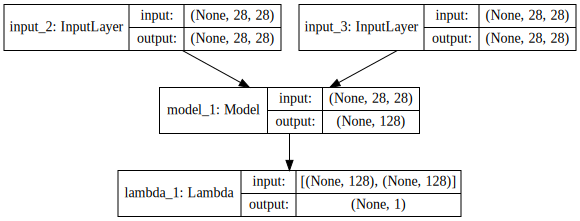

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='Python-MNIST-Siamese.jpg')

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


In [14]:
batch_size = 128 # バッチサイズ
epochs = 20 # エポック

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, 
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))


Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 7s 61us/step - loss: 0.0964 - accuracy: 0.8852 - val_loss: 0.0440 - val_accuracy: 0.9543
Epoch 2/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.0429 - accuracy: 0.9577 - val_loss: 0.0312 - val_accuracy: 0.9699
Epoch 3/20
108400/108400 [==============================] - 6s 59us/step - loss: 0.0300 - accuracy: 0.9708 - val_loss: 0.0274 - val_accuracy: 0.9698
Epoch 4/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.0240 - accuracy: 0.9762 - val_loss: 0.0249 - val_accuracy: 0.9722
Epoch 5/20
108400/108400 [==============================] - 6s 58us/step - loss: 0.0206 - accuracy: 0.9794 - val_loss: 0.0244 - val_accuracy: 0.9718
Epoch 6/20
108400/108400 [==============================] - 6s 57us/step - loss: 0.0182 - accuracy: 0.9819 - val_loss: 0.0246 - val_accuracy: 0.9719
Epoch 7/20
108400/108400 [=============================

In [15]:
# HDF5ファイルでモデル全体とモデルの重みを保存
model.save("Python-MNIST-Siamese.h5")
model.save_weights("Python-MNIST-Siamese-weights.h5")

In [16]:
# pickleで訓練のヒストリーを保存
import pickle
with open('Python-MNIST-Siamese.pkl', 'wb') as h_file:
    pickle.dump(history.history, h_file)

In [40]:
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
# te_pairs[:,0] positive example
# te_pairs[:,1] negative example

# 結果を表示
print("予測:\n", pred)
print(type(pred), pred.shape)
print(pred[0])
print(pred[1])
print(te_pairs[:,0].shape     )
print(te_y)

予測:
 [[0.01220706]
 [1.3698564 ]
 [0.00644376]
 ...
 [1.0088351 ]
 [0.02952316]
 [0.8710604 ]]
<class 'numpy.ndarray'> (17820, 1)
[0.01220706]
[1.3698564]
(17820, 28, 28)
[1 0 1 ... 0 1 0]


In [21]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


In [20]:
# Matplotlibのフォントの制御（大きさや種類）
%matplotlib inline
import numpy as np # Numpy
import matplotlib
import matplotlib.pyplot as plt # 描画ライブラリ
print (matplotlib.rcParams.get('font.family'))
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

font_prop = fm.FontProperties()  
font_prop.set_style('normal')
font_prop.set_weight('light')
font_prop.set_size('12')

fp2 = font_prop.copy()# フォントプロパティ(FP)をコピー
fp2.set_size('20')# フォントプロパティ(FP)をコピー
fp2.set_family('serif')# フォントはSerif(明朝体など）に設定

['sans-serif']


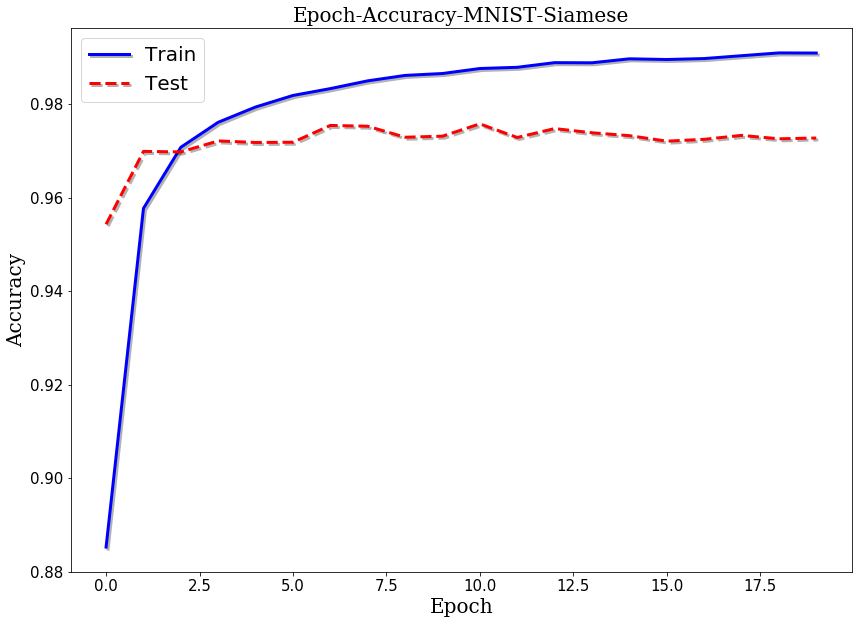

In [23]:
% matplotlib inline
import matplotlib.pyplot as plt

# 精度グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(history.history['accuracy'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history.history['val_accuracy'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=15)
plt.title('Epoch-Accuracy-MNIST-Siamese',fontsize=25,font_properties=fp2)
plt.ylabel('Accuracy',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Train', 'Test'], loc='best', fontsize=20)

plt.savefig('Epoch-Accuracy-MNIST-Siamese.pdf')
plt.show()


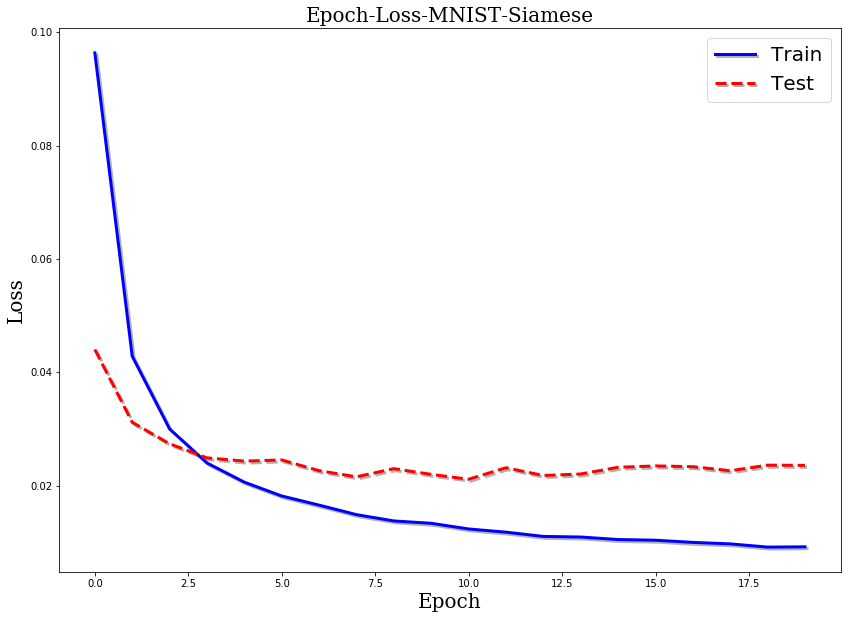

In [24]:
# 損失グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(history.history['loss'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history.history['val_loss'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.title('Epoch-Loss-MNIST-Siamese',fontsize=25,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Train', 'Test'], loc='best', fontsize=20)
plt.savefig('Epoch-Loss-MNIST-Siamese.pdf')
plt.show()

In [25]:
# 未知データのクラスの予測
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)


[0 0 0 ... 0 0 0]


In [15]:
# 混合行列の描画関数の定義
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=25)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=15,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

Confusion matrix, without normalization
[[ 969    0    1    1    0    2    2    1    1    1]
 [   1 1126    1    0    0    0    2    6    0    4]
 [   1    2 1017    3    1    0    0    8    2    0]
 [   1    1    3  991    0    3    1    0    3    4]
 [   0    0    1    0  964    1    3    3    2   10]
 [   3    0    0   10    0  881    7    0   13    7]
 [   3    3    1    0    7    3  943    0    2    0]
 [   1    0    4    2    0    0    0 1002    3    1]
 [   1    3    4    2    1    1    0    2  942    0]
 [   0    0    0    1    9    1    0    6    6  982]]


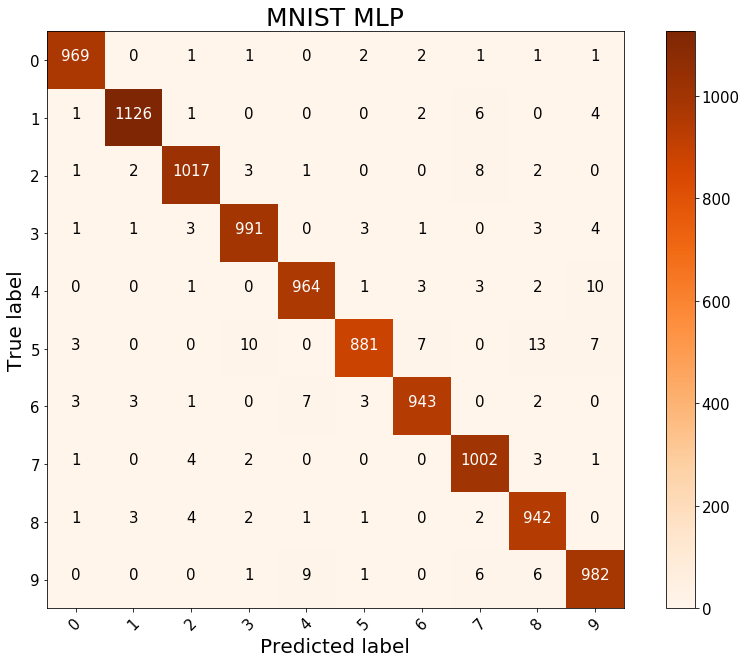

In [16]:
from sklearn.metrics import confusion_matrix # 混合行列
actual = np.argmax(y_test, axis=1)
cm = confusion_matrix(pred_classes, actual)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm, classes=classes, title='MNIST MLP')
plt.show()


In [17]:
count = 0
total = actual.shape[0]
for i in range(total):
    if actual[i] == pred_classes[i]:
        count += 1
accuracy = float(count)/total
print("分類精度 = ",accuracy)

分類精度 =  0.9817
